In [1]:
import tensorflow
import keras
import numpy as np
import matplotlib.pyplot as plt

#from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, SeparableConv2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.applications import imagenet_utils
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

from mobilesqueezenet import conv_block, depthwise_conv_block

#from keras.utils import get_file
#from keras.utils import layer_utils

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


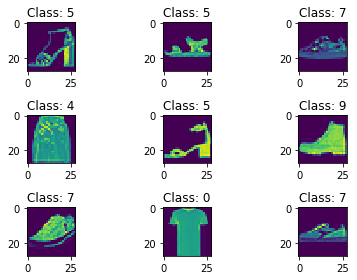

In [2]:
# Load the Fashion MNIST dataset
# Though we're using Keras to import the data, you are free
# to use any deep learning framework you wish.
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Add empty color dimension
x_train = np.expand_dims(x_train, -1)  # shape: (num_samples, 28, 28, 1)
x_test = np.expand_dims(x_test, -1) # shape: (num_samples, 28, 28, 1)
# Plot a few examples. Note that the images are black and white and
# that the labels are provided as integer values 0-9.
num_examples = 9
indexes = np.random.randint(x_train.shape[0], size=(num_examples))

dim = int(np.sqrt(num_examples))

fig = plt.figure()
k = 1
for idx in indexes:
    ax = fig.add_subplot(dim, dim, k)
    ax.imshow(x_train[idx][:, :, 0])
    ax.set_title('Class: %d' % y_train[idx])
    k += 1
fig.tight_layout()
# Preprocess the image to format each pixel to range [0, 1)
x_train = x_train/255.0
x_test = x_test/255.0
# Express labels as one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

In [3]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"
# Modify this cell to complete the functions below.
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '_'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = BatchNormalization()(left)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = BatchNormalization()(right)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)
    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

def depthwise_fire_module(x, fire_id, squeeze=16, expand=64, depth_multiplier = 1, alpha=1.0):
    s_id = 'fire' + str(fire_id) + '/'
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = conv_block(x, squeeze, kernel=(1,1), name=s_id +sq1x1, alpha=alpha)
    left = conv_block(x, expand, name=s_id + exp1x1, alpha=alpha)
    right = depthwise_conv_block(x, expand, name=s_id+exp3x3, depth_multiplier=depth_multiplier, alpha=alpha)
    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [4]:
def SqueezeNet(input_shape=(28,28,1), n_classes=10):
    img_input = Input(shape=input_shape)

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    #x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    #Header of the imagenet model
    x = Dropout(0.5, name='drop9')(x)
    x = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(inputs=img_input, outputs=x, name='squeezenet')
    return model

def DepthwiseSqueezeNet(input_shape=(28,28,1), n_classes=10, depth_multiplier=1, alpha=1.0):
    
    img_input = Input(shape=input_shape)
    
    x = conv_block(img_input, 64, alpha, strides=(2,2))
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='pool1')(x)
    
    x = depthwise_fire_module(x, fire_id=2, squeeze=16, expand=64, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=3, squeeze=16, expand=64, depth_multiplier=depth_multiplier)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = depthwise_fire_module(x, fire_id=4, squeeze=32, expand=128, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=5, squeeze=32, expand=128, depth_multiplier=depth_multiplier)
    #x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = depthwise_fire_module(x, fire_id=6, squeeze=48, expand=192, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=7, squeeze=48, expand=192, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=8, squeeze=64, expand=256, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=9, squeeze=64, expand=256, depth_multiplier=depth_multiplier)
    
    #Header of the imagenet model
    x = Dropout(0.5, name='drop9')(x)
    #x = depthwise_conv_block(x, n_classes, depth_multiplier=depth_multiplier, name='header')
    x = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(inputs=img_input, outputs=x, name='mobile_squeezenet')
    return model

In [5]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 162s 3ms/step - loss: 0.7736 - acc: 0.7789 - val_loss: 0.4628 - val_acc: 0.8488
Epoch 2/10
60000/60000 [==============================] - 162s 3ms/step - loss: 0.4773 - acc: 0.8558 - val_loss: 0.5006 - val_acc: 0.8304
Epoch 3/10
60000/60000 [==============================] - 163s 3ms/step - loss: 0.4002 - acc: 0.8735 - val_loss: 0.4225 - val_acc: 0.8561
Epoch 4/10
60000/60000 [==============================] - 171s 3ms/step - loss: 0.3521 - acc: 0.8854 - val_loss: 0.3929 - val_acc: 0.8671
Epoch 5/10
60000/60000 [==============================] - 165s 3ms/step - loss: 0.3190 - acc: 0.8930 - val_loss: 0.3208 - val_acc: 0.8886
Epoch 6/10
60000/60000 [==============================] - 169s 3ms/step - loss: 0.2958 - acc: 0.9015 - val_loss: 0.2851 - val_acc: 0.9012
Epoch 7/10
60000/60000 [==============================] - 182s 3ms/step - 

In [6]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1, alpha=0.75)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 171s 3ms/step - loss: 0.7798 - acc: 0.7758 - val_loss: 0.5317 - val_acc: 0.8267
Epoch 2/10
60000/60000 [==============================] - 162s 3ms/step - loss: 0.4830 - acc: 0.8525 - val_loss: 0.4683 - val_acc: 0.8525
Epoch 3/10
60000/60000 [==============================] - 161s 3ms/step - loss: 0.3965 - acc: 0.8744 - val_loss: 0.3816 - val_acc: 0.8694
Epoch 4/10
60000/60000 [==============================] - 163s 3ms/step - loss: 0.3491 - acc: 0.8865 - val_loss: 0.3408 - val_acc: 0.8782
Epoch 5/10
60000/60000 [==============================] - 181s 3ms/step - loss: 0.3165 - acc: 0.8943 - val_loss: 0.3448 - val_acc: 0.8854
Epoch 6/10
60000/60000 [==============================] - 165s 3ms/step - loss: 0.2960 - acc: 0.9016 - val_loss: 0.3396 - val_acc: 0.8799
Epoch 7/10
60000/60000 [==============================] - 153s 3ms/step - loss: 0.2768 - acc: 0.9076 - val_loss: 0.3098 - 

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1, alpha=0.5)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 155s 3ms/step - loss: 0.7996 - acc: 0.7691 - val_loss: 0.5324 - val_acc: 0.8282
Epoch 2/10
59360/60000 [============================>.] - ETA: 1s - loss: 0.4911 - acc: 0.8487

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1, alpha=0.25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5, alpha=0.75)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25, alpha=0.75)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5, alpha=0.50)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25, alpha=0.50)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5, alpha=0.25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25, alpha=0.25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
squeeze_model = SqueezeNet()
squeeze_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
squeeze_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))